In [2]:
import numpy as np
import pandas as pd
import random, tqdm
from IPython.display import display, Image
from bracketeer import build_bracket

import lightgbm
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss

import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('../input/ncaaw-march-mania-2021/WDataFiles_Stage2/WNCAATourneyCompactResults.csv')
seeds = pd.read_csv('../input/ncaaw-march-mania-2021/WDataFiles_Stage2/WNCAATourneySeeds.csv')

In [4]:
test = pd.read_csv('../input/ncaaw-march-mania-2021/WDataFiles_Stage2/WSampleSubmissionStage2.csv')
submission = pd.read_csv('../input/ncaaw-march-mania-2021/WDataFiles_Stage2/WSampleSubmissionStage2.csv')

# Data Preprocessing & Feature Engineering

## Train Data

In [5]:
train = train.merge(seeds, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID']).drop('TeamID', axis=1).rename(columns={'Seed': 'WSeed'})
train = train.merge(seeds, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID']).drop('TeamID', axis=1).rename(columns={'Seed': 'LSeed'})

In [6]:
train['WSeed'] = train['WSeed'].str.replace(r'[^0-9]', '').astype('float')
train['LSeed'] = train['LSeed'].str.replace(r'[^0-9]', '').astype('float')

In [7]:
train.drop(['DayNum', 'NumOT'], axis=1, inplace=True)

In [8]:
for index in train.index:
    if random.randint(0, 1) == 1:
        train.at[index, 'WLoc'] = train.at[index, 'WTeamID']
        train.at[index, 'WTeamID'] = train.at[index, 'LTeamID']
        train.at[index, 'LTeamID'] = train.at[index, 'WLoc']
        
        train.at[index, 'WLoc'] = train.at[index, 'WScore']
        train.at[index, 'WScore'] = train.at[index, 'LScore']
        train.at[index, 'LScore'] = train.at[index, 'WLoc']

        train.at[index, 'WLoc'] = train.at[index, 'LSeed']
        train.at[index, 'LSeed'] = train.at[index, 'WSeed']
        train.at[index, 'WSeed'] = train.at[index, 'WLoc']

In [9]:
train.drop('WLoc', axis=1, inplace=True)

In [10]:
train['HomeWin'] = ((train['WScore'] - train['LScore'])> 0).astype(int)
X = train.drop(['WScore', 'LScore', 'HomeWin'], axis=1)
y = train['HomeWin']

In [11]:
train.head()

,Season,WTeamID,WScore,LTeamID,LScore,WSeed,LSeed,HomeWin
0,1998,3422,46,3104,94,15.0,2.0,0
1,1998,3365,63,3112,75,14.0,3.0,0
2,1998,3163,93,3193,52,2.0,15.0,1
3,1998,3266,45,3198,59,10.0,7.0,0
4,1998,3203,74,3208,72,10.0,7.0,1


## Test Data

In [12]:
test['Season'] = test['ID'].apply(lambda x: int(x.split('_')[0]))
test['WTeamID'] = test['ID'].apply(lambda x: int(x.split('_')[1]))
test['LTeamID'] = test['ID'].apply(lambda x: int(x.split('_')[2]))
test.drop(['Pred', 'ID'], axis=1, inplace=True)

In [13]:
test = test.merge(seeds, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID']).drop('TeamID', axis=1).rename(columns={'Seed': 'WSeed'})
test = test.merge(seeds, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID']).drop('TeamID', axis=1).rename(columns={'Seed': 'LSeed'})
test['WSeed'] = test['WSeed'].str.replace(r'[^0-9]', '').astype('float')
test['LSeed'] = test['LSeed'].str.replace(r'[^0-9]', '').astype('float')

In [14]:
test.head()

,Season,WTeamID,LTeamID,WSeed,LSeed
0,2021,3104,3112,7.0,3.0
1,2021,3104,3116,7.0,4.0
2,2021,3104,3124,7.0,2.0
3,2021,3104,3125,7.0,12.0
4,2021,3104,3133,7.0,11.0


# Modeling

In [15]:
lgbm_val_pred = np.zeros(len(y))
lgbm_test_pred = np.zeros(len(test))

In [16]:
kf = KFold(n_splits=10, shuffle=True)
logloss = []

In [17]:
for (trn_idx, val_idx) in tqdm.tqdm(kf.split(X,y)):
    x_train_idx = X.iloc[trn_idx]
    y_train_idx = y.iloc[trn_idx]
    x_valid_idx = X.iloc[val_idx]
    y_valid_idx = y.iloc[val_idx]
    
    lgbm_model = LGBMRegressor(n_estimators=5000, learning_rate=0.05)
    lgbm_model.fit(x_train_idx, y_train_idx, eval_set = ((x_valid_idx,y_valid_idx)),verbose = False, early_stopping_rounds = 1000,categorical_feature=[0,1,2])
    lgbm_test_pred += lgbm_model.predict(test)/10
    logloss.append(log_loss(y_valid_idx, lgbm_model.predict(x_valid_idx))) 

print('Log_Loss:',np.mean(logloss))

10it [00:07,  1.37it/s]

Log_Loss: 0.4636417538175679


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

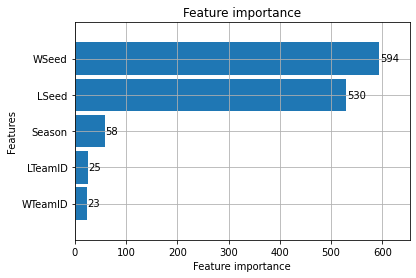

In [18]:
lightgbm.plot_importance(lgbm_model, height=0.9)

# Submission

In [19]:
submission['Pred'] = lgbm_test_pred

In [20]:
submission['Pred'][submission['Pred']<=0.1] = 0
submission['Pred'][submission['Pred']>=0.9] = 1

In [21]:
submission.to_csv('submission.csv', index=False)

In [22]:
submission.head()

,ID,Pred
0,2021_3104_3112,0.373712
1,2021_3104_3116,0.353179
2,2021_3104_3124,0.214051
3,2021_3104_3125,0.642349
4,2021_3104_3133,0.606253


# NCAA Women's Projected Bracket

In [23]:
b = build_bracket(
        outputPath='NCAAW2021.png',
        teamsPath= '../input/ncaaw-march-mania-2021/WDataFiles_Stage2/WTeams.csv',
        seedsPath= '../input/ncaaw-march-mania-2021/WDataFiles_Stage2/WNCAATourneySeeds.csv',
        slotsPath='../input/ncaaw-march-mania-2021/WDataFiles_Stage2/WNCAATourneySlots.csv',
        submissionPath='submission.csv',
        year=2021
)

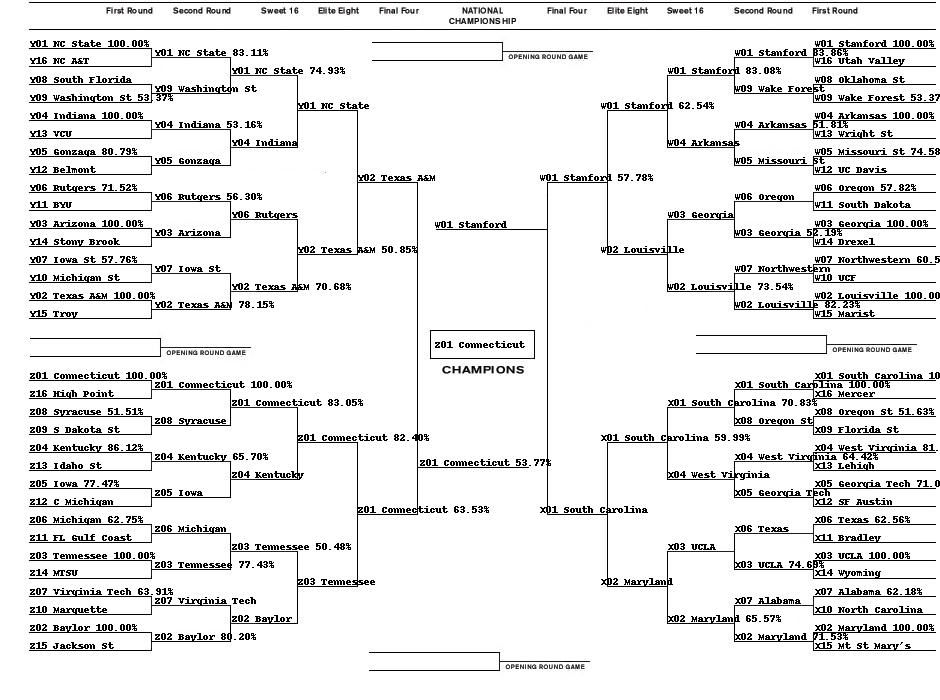

In [24]:
display(Image(filename='./NCAAW2021.png'))